In [1]:
import xarray as xr
import datetime as dt
import glob
import numpy as np
import pandas as pd
import netCDF4 as nc
import warnings; warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import matplotlib
import tqdm
from scipy.ndimage import gaussian_filter

In [2]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_mask(lon,lat,thresh=0.5):
    #Return lsm for a given domain (with lats=lat and lons=lon)
    lsm,nat_lon,nat_lat = get_lsm()
    lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
    lat_ind = np.where((nat_lat >= lat[-1]) & (nat_lat <= lat[0]))[0]
    lsm_domain = lsm[(lat_ind[0]):(lat_ind[-1]+1),(lon_ind[0]):(lon_ind[-1]+1)]
    lsm_domain = np.where(lsm_domain > thresh, 1, 0)

    return lsm_domain

def get_lsm():
    #Load the ERA5 land-sea fraction
    lsm_file = nc.Dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc")
    lsm = np.squeeze(lsm_file.variables["lsm"][0])
    lsm_lon = np.squeeze(lsm_file.variables["longitude"][:])
    lsm_lat = np.squeeze(lsm_file.variables["latitude"][:])
    lsm_file.close()
    return [lsm,lsm_lon,lsm_lat]


def cape_shear_data(var, time, lat, lon, r=0, func=np.max):
    #print("\n",lat, lon, time)
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"\
                            +time.strftime("%Y%m")+"*.nc")[0])[var].sel({"time":time.replace(minute=0)})

    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    mask = get_mask(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    if r>0:
        a,b = np.where( (dist_km <= r) & (mask==1) )
        subset = f.isel_points("points",lat=a, lon=b)
        sliced = subset.apply(func)
    else:
        dist_km = np.where(mask==1, dist_km, 9999)
        temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist_km),dist_km.shape)
        sliced = f.isel({"lon":temp_lon, "lat":temp_lat})

    return pd.DataFrame({"var":[np.round(sliced[v].values,1) for v in var]}, index=var)


In [3]:
details_list = [[\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2006,9,24,1,41)], "rid":"2", "title":"a) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2009,11,20,3,6)], "rid":"2", "title":"b) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,3,6,3,30)], "rid":"2", "title":"c) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,6,17,0,25)], "rid":"2", "title":"d) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,11,18,7,4)], "rid":"2", "title":"e) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,45)], "rid":"2", "title":"f) Melbourne:  UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2012,2,26,9,11)], "rid":"2", "title":"g) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2013,3,21,3,45)], "rid":"2", "title":"h) Melbourne: UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2015,2,28,9,25)], "rid":"2", "title":"i) Melbourne:  UTC"},\
       ], [\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2010,8,2,15,43)], "rid":"71", "title":"a) Sydney:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2012,8,10,4,21)], "rid":"71", "title":"b) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2013,2,23,13,43)], "rid":"71", "title":"c) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2014,10,14,11,39)], "rid":"71", "title":"d) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,3,1,4,34)], "rid":"71", "title":"e) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,12,16,2,3)], "rid":"71", "title":"f) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,1,14,4,20)], "rid":"71", "title":"g) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,6,4,3,42)], "rid":"71", "title":"h) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2017,4,9,8,3)], "rid":"71", "title":"i) Sydney: UTC"},\
       ], [\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2010,12,16,3,25)], "rid":"66", "title":"a) Amberley: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2011,1,18,5,5)], "rid":"66", "title":"b) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2011,10,7,19,22)], "rid":"50", "title":"c) Oakey: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2013,10,18,4,4)], "rid":"50", "title":"d) Oakey: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2013,11,23,9,45)], "rid":"66", "title":"e) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2014,1,23,4,52)], "rid":"50", "title":"f) Oakey UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2016,1,29,4,22)], "rid":"50", "title":"g) Oakey UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2016,12,18,4,14)], "rid":"66", "title":"h) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2018,2,13,7,5)], "rid":"50", "title":"i) Oakey: UTC"},\
       ], [\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2007,10,27,9,3)], "rid":"27", "title":"a) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2008,12,9,6,18)], "rid":"27", "title":"b) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2010,12,7,9,27)], "rid":"27", "title":"c) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2011,11,8,9,47)], "rid":"27", "title":"d) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,1,29,4,42)], "rid":"27", "title":"e) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,11,30,8,33)], "rid":"27", "title":"f) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2014,10,31,7,52)], "rid":"27", "title":"g) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2015,12,7,11,20)], "rid":"27", "title":"h) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2017,12,18,11,30)], "rid":"27", "title":"i) "},\
       ]  ]
           
cnt=1
df_list = []
letter = ["a","b","c","d","e","f","g","h","i"]

for details in tqdm.tqdm(details_list):
    umean = [cape_shear_data(["Umean06"],d["time"][0],d["lat"],d["lon"],r=50,func=np.max).values[0,0] for d in details]
    s06 = [cape_shear_data(["s06"],d["time"][0],d["lat"],d["lon"],r=50,func=np.max).values[0,0] for d in details]
    lr13 = [cape_shear_data(["lr13"],d["time"][0],d["lat"],d["lon"],r=50,func=np.max).values[0,0] for d in details]
    qmean01 = [cape_shear_data(["qmean01"],d["time"][0],d["lat"],d["lon"],r=50,func=np.max).values[0,0] for d in details]    
    times = [d["time"][0] for d in details]
    df_list.append(pd.DataFrame({"time":times,"umean":umean,"s06":s06,"lr13":lr13,"qmean01":qmean01},index=letter))
    

100%|██████████| 4/4 [01:09<00:00, 17.36s/it]


In [4]:
fmax=[np.sort(glob.glob("/g/data/eg3/ab4502/ExtremeWind/points/era5_rad50km_case_study_"+str(y)+"_"+str(y)+"*max.pkl"))[0] for y in np.arange(2005,2019)]
fmin=[np.sort(glob.glob("/g/data/eg3/ab4502/ExtremeWind/points/era5_rad50km_case_study_"+str(y)+"_"+str(y)+"*min.pkl"))[0] for y in np.arange(2005,2019)]
clim = pd.concat([pd.read_pickle(f) for f in fmax], axis=0)
clim_min = pd.concat([pd.read_pickle(f) for f in fmin], axis=0)
l = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning_aus_50.pkl")
clim=l.merge(clim,how="inner",left_on=["date","loc_id"],right_on=["time","loc_id"])
clim_min=l.merge(clim_min,how="inner",left_on=["date","loc_id"],right_on=["time","loc_id"])

[0.001 0.004 0.012 0.02  0.028 0.036 0.044]
[0.001 0.004 0.012 0.02  0.028 0.036 0.044]


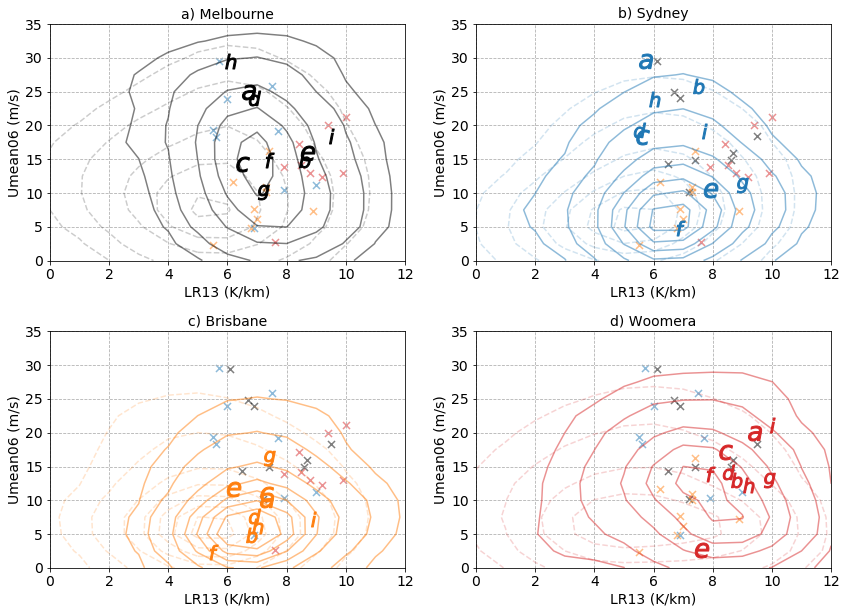

In [16]:
plt.figure(figsize=[14,10])
cnt=1
letter = ["a","b","c","d","e","f","g","h","i"]
letter_cols = ["k","tab:blue","tab:orange","tab:red"]
locs = [["Melbourne"], ["Sydney"], ["Amberley","Oakey"],["Woomera"]]
titles = ["a) Melbourne", "b) Sydney", "c) Brisbane", "d) Woomera"]
for details in (details_list):
    ax=plt.subplot(2,2,cnt)
    
    lr13 = df_list[cnt-1]["lr13"].values
    umean = df_list[cnt-1]["umean"].values    
    for i in np.arange(len(lr13)):
            plt.plot(lr13[i],umean[i],marker="$"+letter[i]+"$",ls="none",color=letter_cols[cnt-1],ms=15,mew=1)

    cnt2=0
    for df in df_list:
        if cnt2==(cnt-1):
            pass
        else:
            lr13 = df["lr13"].values
            umean = df["umean"].values    
            plt.scatter(lr13,umean,color=letter_cols[cnt2],alpha=0.5,s=50,marker="x")
        cnt2=cnt2+1
            
    plt.xlabel("LR13 (K/km)",size=14)
    plt.ylabel("Umean06 (m/s)",size=14)
    plt.gca().grid(ls="--")

    plt.ylim([0,35])
    plt.xlim([0,12])

    #CLIM PLOT
    c_levels = np.insert(np.arange(0.004,0.048,0.008), 0, [0.001])
    H, xe, ye = np.histogram2d(clim[np.in1d(clim.loc_id,locs[cnt-1])].query("lightning<2").lr13.values, clim[np.in1d(clim.loc_id,locs[cnt-1])].query("lightning<2").Umean06.values, 
                           bins=[ np.arange(-0.5,13.5,1), np.arange(-1.25,45.25,2.5)])
    H = gaussian_filter(H, 1)
    x,y = np.meshgrid(([(xe[i] + xe[i+1])/2. for i in np.arange(len(xe)-1)]), ([(ye[i] + ye[i+1])/2. for i in np.arange(len(ye)-1)]))
    c=plt.contour(x,y,H.T/(H.sum()), colors=letter_cols[cnt-1] ,alpha=0.2, levels=c_levels,linestyles="--")
    # labs = plt.clabel(c, c_levels[0:-1:2])
    # [l.set_alpha(1) for l in labs]
    # labs = plt.clabel(c, [c_levels[1]])
    # [l.set_alpha(1) for l in labs]
        
    plt.title(titles[cnt-1],fontsize=14)
    ax.tick_params(labelsize=14)
    
    cnt=cnt+1    
print(c_levels)

    
cnt=1
for details in (details_list):
    ax=plt.subplot(2,2,cnt)

    #CLIM PLOT
    c_levels = np.insert(np.arange(0.004,0.048,0.008), 0, [0.001])
    H, xe, ye = np.histogram2d(clim[np.in1d(clim.loc_id,locs[cnt-1])].query("lightning>=2").lr13.values, clim[np.in1d(clim.loc_id,locs[cnt-1])].query("lightning>=2").Umean06.values, 
                           bins=[ np.arange(-0.5,13.5,1), np.arange(-1.25,45.25,2.5)])
    H = gaussian_filter(H, 1)
    x,y = np.meshgrid(([(xe[i] + xe[i+1])/2. for i in np.arange(len(xe)-1)]), ([(ye[i] + ye[i+1])/2. for i in np.arange(len(ye)-1)]))
    c=plt.contour(x,y,H.T/(H.sum()), colors=letter_cols[cnt-1] ,alpha=0.5, levels=c_levels)
    # labs = plt.clabel(c, c_levels[0:-1:2])
    # [l.set_alpha(1) for l in labs]
    # labs = plt.clabel(c, [c_levels[1]])
    # [l.set_alpha(1) for l in labs]
            
    cnt=cnt+1    
print(c_levels)

plt.subplots_adjust(hspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/lr13_umean_clim_lightning.jpeg",bbox_inches="tight",quality=95)

[0.001 0.006 0.012 0.018 0.024 0.03  0.036 0.042]
[0.001 0.006 0.012 0.018 0.024 0.03  0.036 0.042]


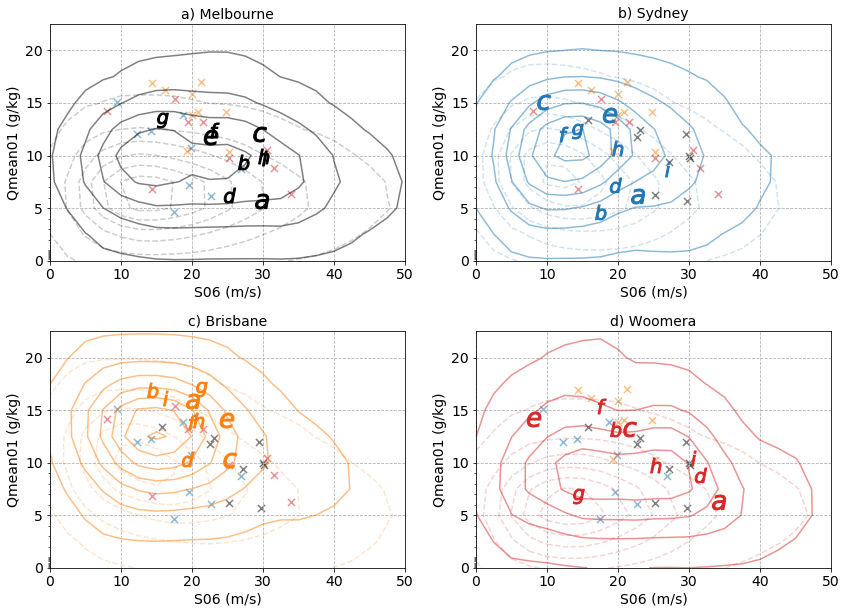

In [15]:
plt.figure(figsize=[14,10])
cnt=1
letter = ["a","b","c","d","e","f","g","h","i"]
letter_cols = ["k","tab:blue","tab:orange","tab:red"]
locs = [["Melbourne"], ["Sydney"], ["Amberley","Oakey"],["Woomera"]]
titles = ["a) Melbourne", "b) Sydney", "c) Brisbane", "d) Woomera"]


for details in (details_list):
    ax=plt.subplot(2,2,cnt)
    
    s06 = df_list[cnt-1]["s06"].values
    qmean01 = df_list[cnt-1]["qmean01"].values    
    for i in np.arange(len(qmean01)):
            plt.plot(s06[i],qmean01[i],marker="$"+letter[i]+"$",ls="none",color=letter_cols[cnt-1],ms=15,mew=1)

    cnt2=0
    for df in df_list:
        if cnt2==(cnt-1):
            pass
        else:
            s06 = df["s06"].values
            qmean01 = df["qmean01"].values    
            plt.scatter(s06,qmean01,color=letter_cols[cnt2],alpha=0.5,s=50,marker="x")
        cnt2=cnt2+1
            
    plt.xlabel("S06 (m/s)",fontsize=14)
    plt.ylabel("Qmean01 (g/kg)",fontsize=14)
    plt.gca().grid(ls="--")

    plt.ylim([0,22.5])
    plt.xlim([0,50])

    #CLIM PLOT
    c_levels = np.insert(np.arange(0.006,0.048,0.006), 0, [0.001])
    H, xe, ye = np.histogram2d(clim[np.in1d(clim.loc_id,locs[cnt-1])].query("lightning<2").s06.values, clim[np.in1d(clim.loc_id,locs[cnt-1])].query("lightning<2").qmean01.values, 
                           bins=[ np.arange(-1.25,71.25,2.5), np.arange(-1.25,31.25,2.5)])
    H = gaussian_filter(H, 1)
    x,y = np.meshgrid(([(xe[i] + xe[i+1])/2. for i in np.arange(len(xe)-1)]), ([(ye[i] + ye[i+1])/2. for i in np.arange(len(ye)-1)]))
    c=plt.contour(x,y,H.T/(H.sum()), levels=c_levels, colors=letter_cols[cnt-1],alpha=0.2,linestyles="--")
    # labs = plt.clabel(c, c_levels[0:-1:2])
    # [l.set_alpha(1) for l in labs]
    # labs = plt.clabel(c, [c_levels[1]])
    # [l.set_alpha(1) for l in labs]
    
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(subs="all"))
    ax.tick_params(labelsize=14)
    
    plt.title(titles[cnt-1],size=14)
    
    cnt=cnt+1    
print(c_levels)
    
cnt=1
for details in (details_list):
    ax=plt.subplot(2,2,cnt)
    

    #CLIM PLOT
    c_levels = np.insert(np.arange(0.006,0.048,0.006), 0, [0.001])
    H, xe, ye = np.histogram2d(clim[np.in1d(clim.loc_id,locs[cnt-1])].query("lightning>=2").s06.values, clim[np.in1d(clim.loc_id,locs[cnt-1])].query("lightning>=2").qmean01.values, 
                           bins=[ np.arange(-1.25,71.25,2.5), np.arange(-1.25,31.25,2.5)])
    H = gaussian_filter(H, 1)
    x,y = np.meshgrid(([(xe[i] + xe[i+1])/2. for i in np.arange(len(xe)-1)]), ([(ye[i] + ye[i+1])/2. for i in np.arange(len(ye)-1)]))
    c=plt.contour(x,y,H.T/(H.sum()), levels=c_levels, colors=letter_cols[cnt-1],alpha=0.5)
    # labs = plt.clabel(c, c_levels[0:-1:2])
    # [l.set_alpha(1) for l in labs]
    # labs = plt.clabel(c, [c_levels[1]])
    # [l.set_alpha(1) for l in labs]
    
    cnt=cnt+1    
print(c_levels)
    
plt.subplots_adjust(hspace=0.3)
    
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/s06_qmean01_clim_lightning.jpeg",bbox_inches="tight",quality=95)    
